In [ ]:
# change

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [67]:
player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset


In [85]:
# functions
def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 1
    else:
        label = 0
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))

In [86]:
# load data
game_path = './game_data/'
player_path = './player_data/'

game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2022' not in path]
game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2022' in path]

player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2022' not in path and '2023' not in path]
player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2022' in path]

train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

train_player_data = get_player_data(player_csvs_train)
test_player_data = get_player_data(player_csvs_test)

In [90]:
# get format
X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

len(X_train), len(y_train), len(X_test), len(y_test)

  0%|          | 0/15473 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

(11641, 11641, 1704, 1704)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.80      0.68       912
           1       0.60      0.34      0.43       792

    accuracy                           0.59      1704
   macro avg       0.59      0.57      0.55      1704
weighted avg       0.59      0.59      0.56      1704



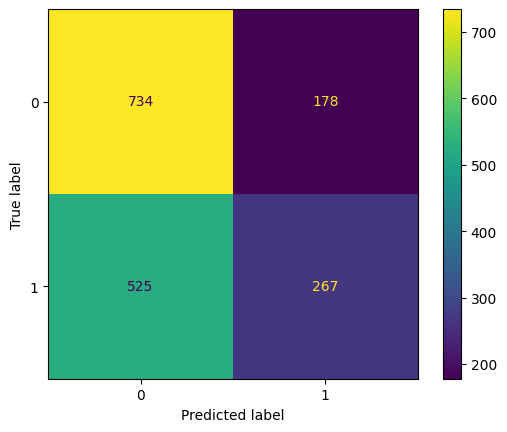

In [92]:
# SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = svm.SVC()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

class_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

print("Classification Report:")
print(class_report)

In [84]:
# forests and feature ranking
hypers = classification_hyper_param_search(X, y, 10, 10)
xb_hypers = hypers[0]['best_params']
rf_hypers = hypers[1]['best_params']
ranking = classification_ranking(X, y, rf_hypers, xb_hypers)
scoring = voting(ranking)
#plot_ranking(scoring, title='Classification example')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
"""
EXTRA
def get_player_data(paths):
    player_dfs = [pd.read_csv(path) for path in paths]
    player_dfs = [df.assign(Name=df['last_name, first_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]).lower())).drop(columns=['player_id', 'last_name, first_name']) for df in player_dfs]
    combined_player = pd.concat(player_dfs).groupby('Name', as_index=False).mean()
    final_player = combined_player.set_index('Name').T.to_dict('list')
    return final_player

df.iloc[:, 102] # visiting pitchers
df.iloc[:, 104] # home pitchers
df.iloc[:, 105:132] # visiting players
df.iloc[:, 132:159] # home players
df.iloc[:, 9] # visiting score
df.iloc[:, 10] # home score
df.iloc[:, 3] # visiting team
df.iloc[:, 6] # home team
visiting_teams = df.iloc[:, 3].tolist()
home_teams = df.iloc[:, 6].tolist()
"""